## MSE performance of gradient descent (GD) with Chebyshev steps (CHGD) and other accelerated GD

* This code is used to generate Figures 13 in the following manuscript:

S. Takabe and T. Wadayama, "Convergence Acceleration via Chebyshev Step:
Plausible Interpretation of Deep-Unfolded Gradient Descent"


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

device = torch.device('cuda') # 'cpu' or 'cuda'

In [2]:
## model parameters 
n = 300
m = 450
bs_test = 10000 # number of samples 

itr = 16 # length of Chebyshev steps ($T$ in the paper)
repeat = 4 # number of repat of CHGD 
itr_tot = itr*repeat # total number of iterations of GDs
##

In [3]:
# generate A
np.random.seed(seed=32)
A=np.random.normal(0,1/np.sqrt(n),(n,m)) #
W = np.dot(A,A.T)
eig = np.linalg.eig( W )
eig = eig[0] # eigenvalues

A = torch.Tensor(np.diag(eig)).to(device)
eig1 = np.sort(eig)[::-1]

print("condition number, min. and max. eigenvalues of A")
print(np.max(eig)/np.min(eig),np.max(eig),np.min(eig))


condition number, min. and max. eigenvalues of A
88.10381317130214 4.933429045923184 0.05599563592475858


In [4]:
def grad_numerical_f(x, bs):
    return torch.mm(x,A)

In [5]:
solution = torch.zeros(bs_test,n).to(device)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
class GD(nn.Module):
    def __init__(self, num_itr):
        super(GD, self).__init__()
    def forward(self, num_itr, bs, gamma):
        traj = []
        s = torch.normal(1.0*torch.ones(bs,n),1.0 ).to(device) 
        traj.append(s)

        for i in range(num_itr):
            s = s - abs(gamma) * grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj

In [8]:
class Momentum(nn.Module):
    def __init__(self, num_itr):
        super(Momentum, self).__init__()
    def forward(self, num_itr, bs, gamma, beta):
        traj = []
        s_t = torch.normal(1.0*torch.ones(bs,n),1.0 ).to(device) 
        s = s_t
        traj.append(s)
        s_m1 = torch.zeros(bs,n).to(device)
        
        for i in range(num_itr):
            s = s_t - abs(gamma) * grad_numerical_f(s_t, bs) + beta * (s_t-s_m1)
            traj.append(s)
            s_m1 = s_t # s_{t-1}
            s_t = s # s_{t}
            
        return s, traj

In [9]:
class Cheby(nn.Module):
    def __init__(self, num_itr):
        super(Cheby, self).__init__()
    def forward(self, num_itr, bs, max_itr, lam_min, lam_max):
        traj = []
        s = torch.normal(1.0*torch.ones(bs,n),1.0 ).to(device) 
        traj.append(s)
        
        gamma = []
        # Chebyshev nodes
        for i in range(max_itr):
            gamma.append( 1.0/((lam_max+lam_min)*0.5+(lam_max-lam_min)*0.5*math.cos( (2*i+1)/(2*max_itr) *math.pi)) )
        
        num_list = range(max_itr)
        
        for i in range(num_itr):
            i_ = i % max_itr  
            s = s - gamma[num_list[i_]] * grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj

In [10]:
class Cheby_semi(nn.Module):
    def __init__(self, num_itr):
        super(Cheby_semi, self).__init__()
    def forward(self, num_itr, bs, max_itr, lam_min, lam_max):
        traj = []
        s_t = torch.normal(1.0*torch.ones(bs,n),1.0 ).to(device) 
        s = s_t
        traj.append(s)
        s_m1 = torch.zeros(bs,n).to(device)
        
        kappa = lam_max/lam_min
        rho = 1.0-1.0/kappa
        gamma = 1 
        eta = 1.0/lam_max
        
        for i in range(num_itr):
            s = s_t - gamma * eta* grad_numerical_f(s_t, bs) + (gamma-1.0) * (s_t-s_m1)
            traj.append(s)
            if i==0:
                gamma = 2.0/(2.0-rho**2.0)
            else:
                gamma = 1.0/(1.0-rho**2.0*gamma*0.25) # update
            s_m1 = s_t # s_{t-1}
            s_t = s # s_{t}
        
        for i in range(num_itr):
            s = s - gamma * eta* grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj

In [11]:
gd_model = GD(itr).to(device)
mom_model = Momentum(itr).to(device)
ch_model = Cheby(itr).to(device)
semi_model = Cheby_semi(itr).to(device)


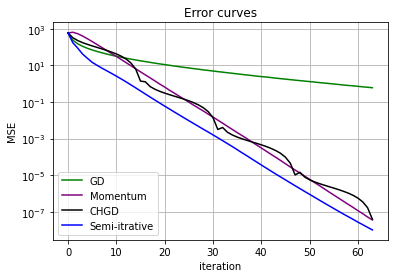

In [12]:
bs = bs_test
eps = 1e-60

## standard GD with optimal constant step size
gamma = 2/(np.min(eig)+np.max(eig)) # optimal 
norm_list_GD = []
itr_list = []
for i in range(itr_tot):
    s_hat, _ = gd_model(i, bs, gamma)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/bs
    norm_list_GD.append((err+eps))
    itr_list.append(i)
plt.plot(itr_list, norm_list_GD, color="green", label="GD")

# momentum (MOM)
kappa = np.min(eig)/np.max(eig)
beta = ((math.sqrt(kappa)-1)/(math.sqrt(kappa)+1) )**2.0 # optimal
gamma = 2.0*(1+beta)/(np.max(eig)+np.min(eig)) # optimal
#print(beta,gamma)

norm_list_MOM = []
for i in range(itr_tot):
    s_hat, _ = mom_model(i, bs, gamma, beta)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/bs
    norm_list_MOM.append((err+eps))
plt.plot(itr_list, norm_list_MOM, color="purple", label="Momentum")

# GD with Chebyshev steps (CHGD)
norm_list_CH = []
for i in range(itr_tot):
    s_hat, _ = ch_model(i, bs, itr, np.min(eig), np.max(eig))
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/bs
    norm_list_CH.append((err+eps))
    
plt.plot(itr_list, norm_list_CH, color="black", label="CHGD")

# Chebyshev semi-itr (CH-semi)
norm_list_semi = []
for i in range(itr_tot):
    s_hat, _ = semi_model(i, bs, itr, np.min(eig), np.max(eig))
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/bs
    norm_list_semi.append((err+eps))

plt.plot(itr_list, norm_list_semi, color="blue", label="Semi-itrative")

plt.title("Error curves")
plt.grid()
plt.xlabel("iteration")
plt.ylabel("MSE")
plt.yscale("log")
plt.legend()
plt.show()


In [13]:
# MSE performance
print("#_ ", "n=", n, "m=",m, "itr=",itr, "bs=", bs,
      "seed=32","lmax=", np.max(eig),"lmin=", np.min(eig), "kappa=",np.max(eig)/np.min(eig) )
print("#_ itr., Cheby, GD, MOM, CH-semi")
for i in range(itr_tot):
    print(i+1, norm_list_CH[i], norm_list_GD[i], norm_list_MOM[i], norm_list_semi[i])


#_  n= 300 m= 450 itr= 16 bs= 10000 seed=32 lmax= 4.933429045923184 lmin= 0.05599563592475858 kappa= 88.10381317130214
#_ itr., Cheby, GD, MOM, CH-semi
1 600.24365 599.65665 600.2452 600.16015
2 326.443325 240.1553 656.11795 174.1863125
3 230.885175 153.4479125 544.6894 89.1316375
4 177.8978875 111.8844125 409.315925 42.21001875
5 143.1611375 87.07105625 291.82545 24.78208125
6 117.4577625 70.36704375 203.109325 14.8886984375
7 97.2844 58.58120625 139.58355 10.26448515625
8 80.6770625 49.448021875 96.5407375 7.165834375
9 66.59326875 42.254140625 66.41960625 5.159329296875
10 53.9728875 36.50299375 45.287559375 3.6957921875
11 42.774696875 32.125046875 31.193096875 2.6205408203125
12 32.292159375 28.244853125 21.2795703125 1.8473138671875
13 22.60514375 25.0063234375 14.401803125 1.277649609375
14 13.84541875 22.247046875 9.77221796875 0.87641318359375
15 6.406426953125 19.9743875 6.59769140625 0.598348486328125
16 1.3989779296875 17.9551109375 4.4985 0.405826513671875
17 1.28044160156